### 分组测试经典方法
2022-07-17
- univ矩阵要求：所有值都没有缺失

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import sys
sys.path.append('C:/Users/Administrator/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/18316/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/Handsome Bad Guy/Desktop/Repositories/Low-Frequency-Spread-Estimator')

from SpreadEstimator.SpreadEstimator import SpreadEstimator
from mytools.AutoTester import AutoTester

from time import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
se = SpreadEstimator()

### 构造三组univ

In [3]:
univ = se.data.data_dic['volume'] > 0  # 当天有交易
th = 0.8

univ_2 = []
for i in range(2081):
    if np.sum(se.data.data_dic['close'][univ[:,i],i]>10) >= th * 243:
        univ_2.append(1)
    else:
        univ_2.append(0)
univ_2 = np.array(univ_2) > 0
print(np.sum(univ_2))
univ_2 = np.repeat(univ_2.reshape(1,2081), 243, 0)

univ_1 = []
for i in range(2081):
    if np.sum(se.data.data_dic['close'][univ[:,i],i]>5) >= th * 243:
        univ_1.append(1)
    else:
        univ_1.append(0)
univ_1 = np.array(univ_1) > 0
univ_1 = np.repeat(univ_1.reshape(1,2081), 243, 0) & (~univ_2)
print(np.sum(univ_1[0]))

univ_0 = (~univ_2) & (~univ_1)
print(np.sum(univ_0[0]))

univ_0 = univ_0 & univ
univ_1 = univ_1 & univ
univ_2 = univ_2 & univ

all_univ = [univ_0, univ_1, univ_2]

854
695
532


### 在3组股票中测试

In [12]:
def test_cs(signal, target, univ, back: int = 1):
    corr = []
    for i in range(signal.shape[0]):
        if i < back-1:
            continue
        t = np.nanmean(target[i-back+1: i+1], axis=0)
        se = (~np.isnan(t)) & (~np.isnan(signal[i])) & univ[i]
        if np.sum(se) < 2:
            continue
        corr.append(np.corrcoef(signal[i, se], t[se])[0, 1])
    print('{:.4f}'.format(np.nanmean(corr)))
    return corr

def test_ts(signal, target, univ, back: int = 1):
    corr = []
    new_t = np.zeros((len(target)-back+1, target.shape[1]))
    for i in range(new_t.shape[0]):
        new_t[i] = np.nanmean(target[i:i+back])
    for i in range(signal.shape[1]):
        t = new_t[:, i]
        se = (~np.isnan(t)) & (~np.isnan(signal[back-1:, i])) & univ[back-1:, i]
        if np.sum(se) < 2:
            continue
        corr.append(np.corrcoef(signal[back-1:, i][se], t[se])[0, 1])
    print('{:.4f}'.format(np.mean(corr)))
    return corr

In [5]:
def test_rela(signal, all_univ):
    print('rela cs')
    for u in all_univ:
        _ = test_cs(signal, se.data.spread_dic['relative_spread'], u, 20)
    print()

    print('rela ts')
    for u in all_univ:
        _ = test_ts(signal, se.data.spread_dic['relative_spread'], u, 20)
    print()

    print('vol_wtd_rel_bas cs ')
    for u in all_univ:
        _ = test_cs(signal, se.data.spread_dic['vol_wtd_rel_bas'], u, 20)
    print()

    print('vol_wtd_rel_bas ts ')
    for u in all_univ:
        _ = test_ts(signal, se.data.spread_dic['vol_wtd_rel_bas'], u, 20)
        
def test_spread(signal, all_univ):
    print('spread cs')
    for u in all_univ:
        _ = test_cs(signal, se.data.spread_dic['spread'], u, 20)
    print()

    print('spread ts')
    for u in all_univ:
        _ = test_ts(signal, se.data.spread_dic['spread'], u, 20)

#### HL

In [79]:
beta = 'prod{tsmean{powv{minus{logv{high},logv{low}},2},2},2}'

high_1 = 'logv{tsdelay{high,1}}'
low_1 = 'logv{tsdelay{low,1}}'
con_1 = 'condition{gt{logv{low},logv{tsdelay{close,1}}},minus{logv{low},logv{tsdelay{close,1}}},minus{close,close}}'
con_2 = 'condition{lt{logv{high},logv{tsdelay{close,1}}},minus{logv{high},logv{tsdelay{close,1}}},minus{close,close}}'
con = 'add{' + con_1 + ',' + con_2 + '}'
high_2 = 'minus{logv{high},' + con + '}'
low_2 = 'minus{logv{low},' + con + '}'
high = 'condition{ge{' + high_1 + ',' + high_2 + '},' + high_1 + ',' + high_2 + '}'
low = 'condition{le{' + low_1 + ',' + low_2 + '},' + low_1 + ',' + low_2 + '}'

gamma = 'powv{minus{' + high + ',' + low + '},2}'
alpha = 'div{prod{' + 'powv{' + beta + ',0.5},0.4142},0.1716}'
fml = 'minus{' + alpha + ',' + 'powv{' + 'div{' + gamma + ',0.1716},0.5}}'

fml = 'div{' + 'minus{expv{' + fml + '},1},' + 'add{expv{' + fml + '},1}}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'

fml = 'div{' + 'minus{expv{' + fml + '},1},' + 'add{expv{' + fml + '},1}}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')
print()

test_rela(signal, all_univ)

mean corr: -0.2082, positive_corr_ratio: 0.0000, corr_IR: -3.6871

rela cs
-0.1406
-0.2409
-0.0057

rela ts
0.0038
0.0134
0.0583

vol_wtd_rel_bas cs 
-0.1259
-0.1824
0.0340

vol_wtd_rel_bas ts 
0.0082
0.0233
0.0738


In [80]:
beta = 'prod{tsmean{powv{minus{high,low},2},2},2}'
high_1 = 'tsdelay{high,1}'
low_1 = 'tsdelay{low,1}'
con_1 = 'condition{gt{low,tsdelay{close,1}},minus{low,tsdelay{close,1}},minus{close,close}}'
con_2 = 'condition{lt{high,tsdelay{close,1}},minus{high,tsdelay{close,1}},minus{close,close}}'
con = 'add{' + con_1 + ',' + con_2 + '}'
high_2 = 'minus{high,' + con + '}'
low_2 = 'minus{low,' + con + '}'
high = 'condition{ge{' + high_1 + ',' + high_2 + '},' + high_1 + ',' + high_2 + '}'
low = 'condition{le{' + low_1 + ',' + low_2 + '},' + low_1 + ',' + low_2 + '}'

gamma = 'powv{minus{' + high + ',' + low + '},2}'
alpha = 'div{prod{' + 'powv{' + beta + ',0.5},0.4142},0.1716}'
fml = 'minus{' + alpha + ',' + 'powv{' + 'div{' + gamma + ',0.1716},0.5}}'

fml = 'div{' + 'minus{expv{' + fml + '},1},' + 'add{expv{' + fml + '},1}}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')

print()
test_spread(signal, all_univ)

mean corr: -0.4630, positive_corr_ratio: 0.0000, corr_IR: -16.7947

spread cs
0.3754
0.3429
0.6773

spread ts
0.2615
0.2902
0.2399


#### Roll

In [82]:
a = 'tsdelta{logv{close},1}'
b = 'tsdelay{tsdelta{logv{close},1},1}'
fml = 'prod{' + a + ',' + b + '}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='spread')

print()
test_rela(signal, all_univ)

mean corr: 0.0994, positive_corr_ratio: 0.9279, corr_IR: 1.2409

rela cs
-0.0569
-0.1277
-0.0273

rela ts
0.0944
0.1013
0.1162

vol_wtd_rel_bas cs 
-0.0368
-0.0531
0.0386

vol_wtd_rel_bas ts 
0.1317
0.1464
0.1623


In [83]:
a = 'tsdelta{close,1}'
b = 'tsdelay{tsdelta{close,1},1}'
fml = 'prod{' + a + ',' + b + '}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='spread')
print()
test_spread(signal, all_univ)

mean corr: 0.7924, positive_corr_ratio: 1.0000, corr_IR: 18.7505

spread cs
0.3684
0.3479
0.7697

spread ts
0.1417
0.1719
0.1541


#### CHL

In [84]:
a = 'minus{logv{tsdelay{close,1}},div{add{logv{tsdelay{high,1}},logv{tsdelay{low,1}}},2}}'
b = 'minus{logv{tsdelay{close,1}},div{add{logv{high},logv{low}},2}}'
fml = 'prod{' + a + ',' + b + '}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')

print()
test_rela(signal, all_univ)

mean corr: -0.2317, positive_corr_ratio: 0.0000, corr_IR: -3.9265

rela cs
-0.1404
-0.2069
-0.0750

rela ts
0.0726
0.0650
0.1010

vol_wtd_rel_bas cs 
-0.1223
-0.1379
-0.0192

vol_wtd_rel_bas ts 
0.0948
0.0973
0.1369


In [85]:
a = 'minus{tsdelay{close,1},div{add{tsdelay{high,1},tsdelay{low,1}},2}}'
b = 'minus{tsdelay{close,1},div{add{high,low},2}}'
fml = 'prod{' + a + ',' + b + '}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')

print()
test_spread(signal, all_univ)

mean corr: -0.3688, positive_corr_ratio: 0.0000, corr_IR: -8.7364

spread cs
0.3460
0.3128
0.7810

spread ts
0.2436
0.2703
0.2286


### bas

In [86]:
fml = 'last_rel_bas'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')
print()
test_rela(signal, all_univ)

mean corr: 0.7343, positive_corr_ratio: 1.0000, corr_IR: 7.4584

rela cs
0.8742
0.4329
0.3853

rela ts
0.1908
0.1037
0.0548

vol_wtd_rel_bas cs 
0.8727
0.4297
0.3816

vol_wtd_rel_bas ts 
0.1807
0.0991
0.0552


In [87]:
fml = 'last_bas'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')

print()
test_spread(signal, all_univ)

mean corr: -0.0908, positive_corr_ratio: 0.0446, corr_IR: -2.3502

spread cs
0.2424
0.3101
0.5234

spread ts
0.0131
0.0288
0.0361


### Gibbs

In [10]:
path = r"C:\Users\18316\Desktop\Repositories\Low-Frequency-Spread-Estimator\estimator\cache"
gibbs = np.zeros((243, 2081), dtype=np.float32)
for i in range(10):
    gibbs[20+21*i:41+21*i] = np.load('{}/{}.npy'.format(path, i))

In [13]:
test_rela(gibbs, all_univ)

rela cs
0.0015
-0.0051
-0.0048

rela ts
0.1189
0.1182
0.1198

vol_wtd_rel_bas cs 
0.0018
-0.0064
-0.0046

vol_wtd_rel_bas ts 
0.1492
0.1483
0.1500


### 查看10元以上组合的市值占比

In [70]:
ave_cap = np.nanmean(se.data.data_dic['volume']*se.data.data_dic['close'], axis=0)
ave_cap = np.nanmean(se.data.data_dic['cap'], axis=0)
print(np.sum(ave_cap[np.sum(univ_0, axis=0)>0])/np.sum(ave_cap))
print(np.sum(ave_cap[np.sum(univ_1, axis=0)>0])/np.sum(ave_cap))
print(np.sum(ave_cap[np.sum(univ_2, axis=0)>0])/np.sum(ave_cap))

0.12534970276961246
0.196356803394121
0.6782934938362665


In [69]:
ave_cap = np.nanmean(se.data.data_dic['volume']*se.data.data_dic['close'], axis=0)
print(np.sum(ave_cap[np.sum(univ_0, axis=0)>0])/np.sum(ave_cap))
print(np.sum(ave_cap[np.sum(univ_1, axis=0)>0])/np.sum(ave_cap))
print(np.sum(ave_cap[np.sum(univ_2, axis=0)>0])/np.sum(ave_cap))

0.15209941578100805
0.2337683401885248
0.6141322440304672


In [68]:
print(np.sum(np.sum(univ_0, axis=0)>0))
print(np.sum(np.sum(univ_1, axis=0)>0))
print(np.sum(np.sum(univ_2, axis=0)>0))

532
695
854


### 绘制相对价差和收盘价的散点图

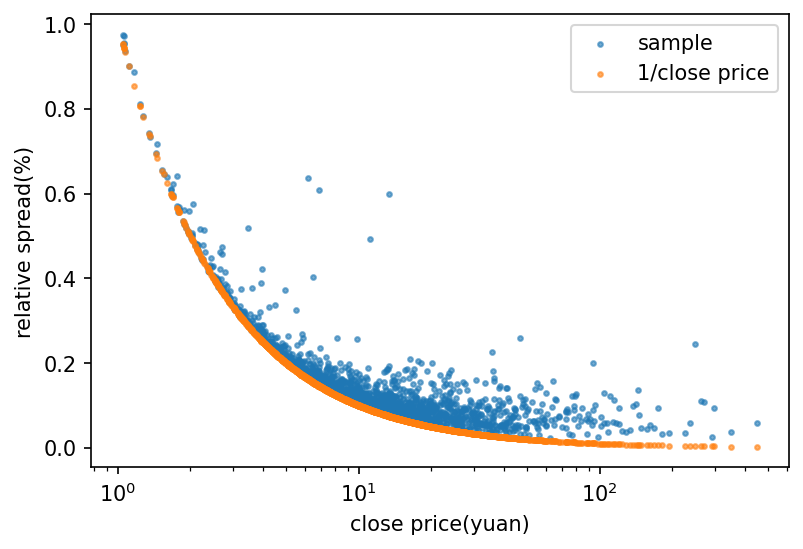

In [63]:
plt.figure(dpi=150)
plt.scatter(se.data.data_dic['close'][242, univ[242]], 
            se.data.spread_dic['relative_spread'][242, univ[242]]*100, alpha=0.6, s=5, label='sample')
plt.scatter(se.data.data_dic['close'][242, univ[242]], 
            1/se.data.data_dic['close'][242, univ[242]], alpha=0.6, s=5, label='1/close price')
plt.legend()
plt.xlabel('close price(yuan)')
plt.ylabel('relative spread(%)')
plt.xscale('log')
plt.show()

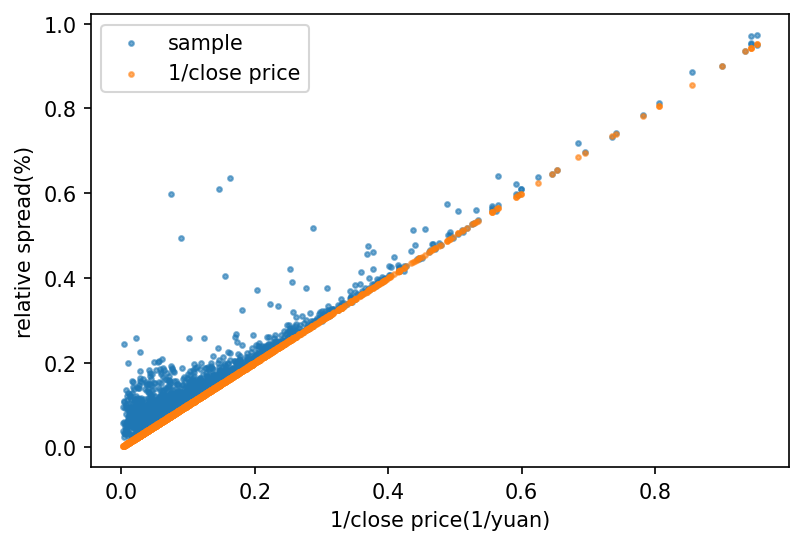

In [61]:
plt.figure(dpi=150)
plt.scatter(1/se.data.data_dic['close'][242, univ[242]], 
            se.data.spread_dic['relative_spread'][242, univ[242]]*100, alpha=0.6, s=5, label='sample')
plt.scatter(1/se.data.data_dic['close'][242, univ[242]], 
            1/se.data.data_dic['close'][242, univ[242]], alpha=0.6, s=5, label='1/close price')
plt.legend()
plt.legend()
plt.xlabel('1/close price(1/yuan)')
plt.ylabel('relative spread(%)')
plt.show()